<div style="text-align: center;">
    <h1>Sirene vs RNE</h1>
</div>

Nous avons extrait sensiblement les mêmes informations de bases de données gouvernementales dans ces notebooks :

- [Sirene](../Notebooks/2.%20Sirene.ipynb)
- [RNE](../Notebooks/1.%20Registre%20national%20des%20entreprises.ipynb)

Nous allons ici les comparer l'une et l'autre et voir quel dataset final utiliser. 

Le dataset final sera une liste la plus exhaustive possible des établissements (au sens du SIRET) en activité en France et de leur localisation (à la maille de la commune).

## Import des librairies

In [11]:
! pip install -q missingno


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import missingno as msno
import re

# Comparaison des données

### Comparaison de la taille des fichiers et du nombre de références

Sirene semble plus exhaustif

In [3]:
path_rne = "../Données nationales/RNE.parquet"
path_sirene = "../Données nationales/StockEtablissement_utf8.parquet"

# poids en Mo des fichiers
poids_rne = os.path.getsize(path_rne)/1024**2
poids_sirene = os.path.getsize(path_sirene)/1024**2

print("poids du fichier RNE : {:.2f} Mo".format(poids_rne))
print("poids du fichier SIRENE : {:.2f} Mo".format(poids_sirene))


poids du fichier RNE : 313.78 Mo
poids du fichier SIRENE : 350.91 Mo


In [4]:
%%time
df_rne = pd.read_parquet(path_rne)
df_sirene = pd.read_parquet(path_sirene)

CPU times: user 13.1 s, sys: 6.68 s, total: 19.8 s
Wall time: 16.4 s


In [6]:
print("Nombre d'établissements dans le fichier RNE : {:,}".format(len(df_rne)))
print("Nombre d'établissements dans le fichier SIRENE : {:,}".format(len(df_sirene)))

Nombre d'établissements dans le fichier RNE : 7,831,770
Nombre d'établissements dans le fichier SIRENE : 15,438,212


## Quelles sont les données à disposition ?

Les deux bases ont les mêmes variables, à savoir :

- siret
- nomCommmercial (nommé enseigneEtablissement ou denominationUsuelleEtablissement pour Sirene)
- codeInseeCommune
- codeApe
- adresse
- diffusion commerciale

On ajoute à cela pour Sirene :
- NomenclatureActivitePrincipaleEtablissement

<Axes: >

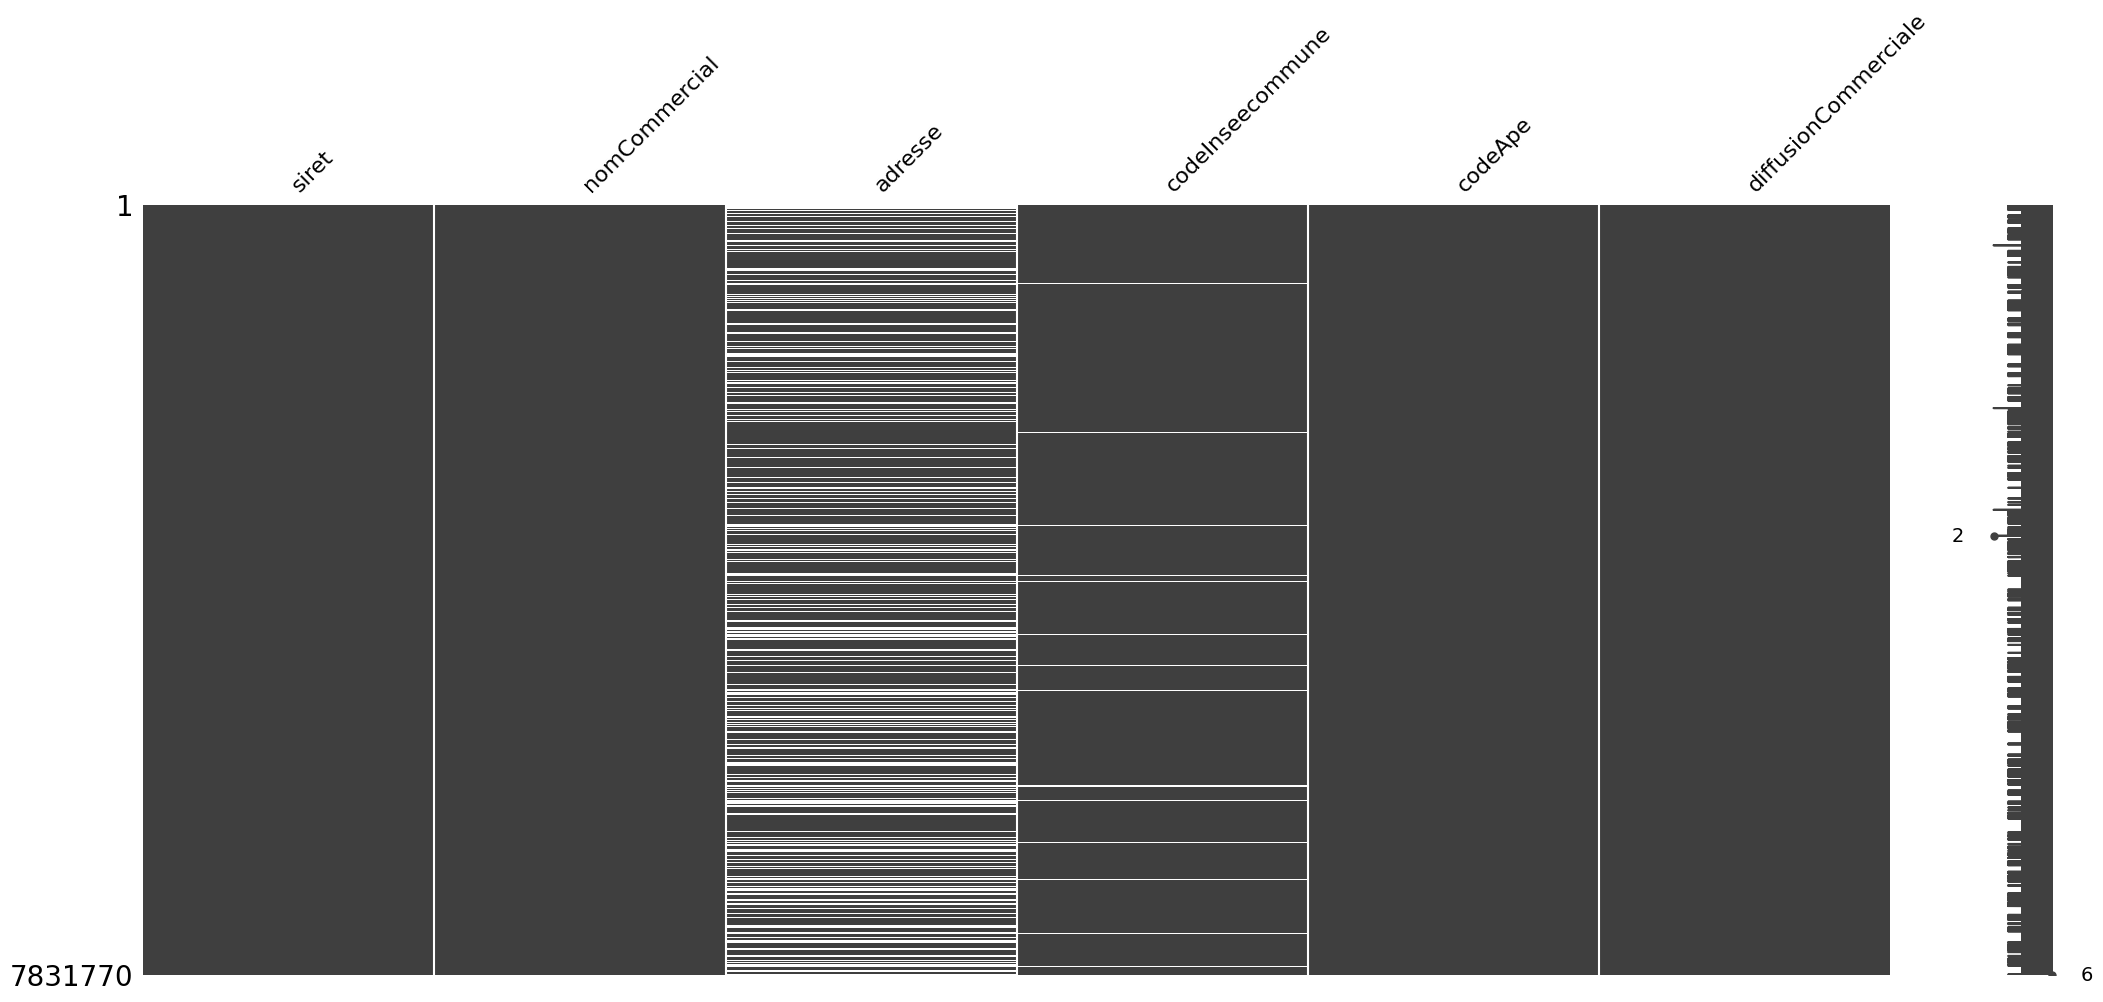

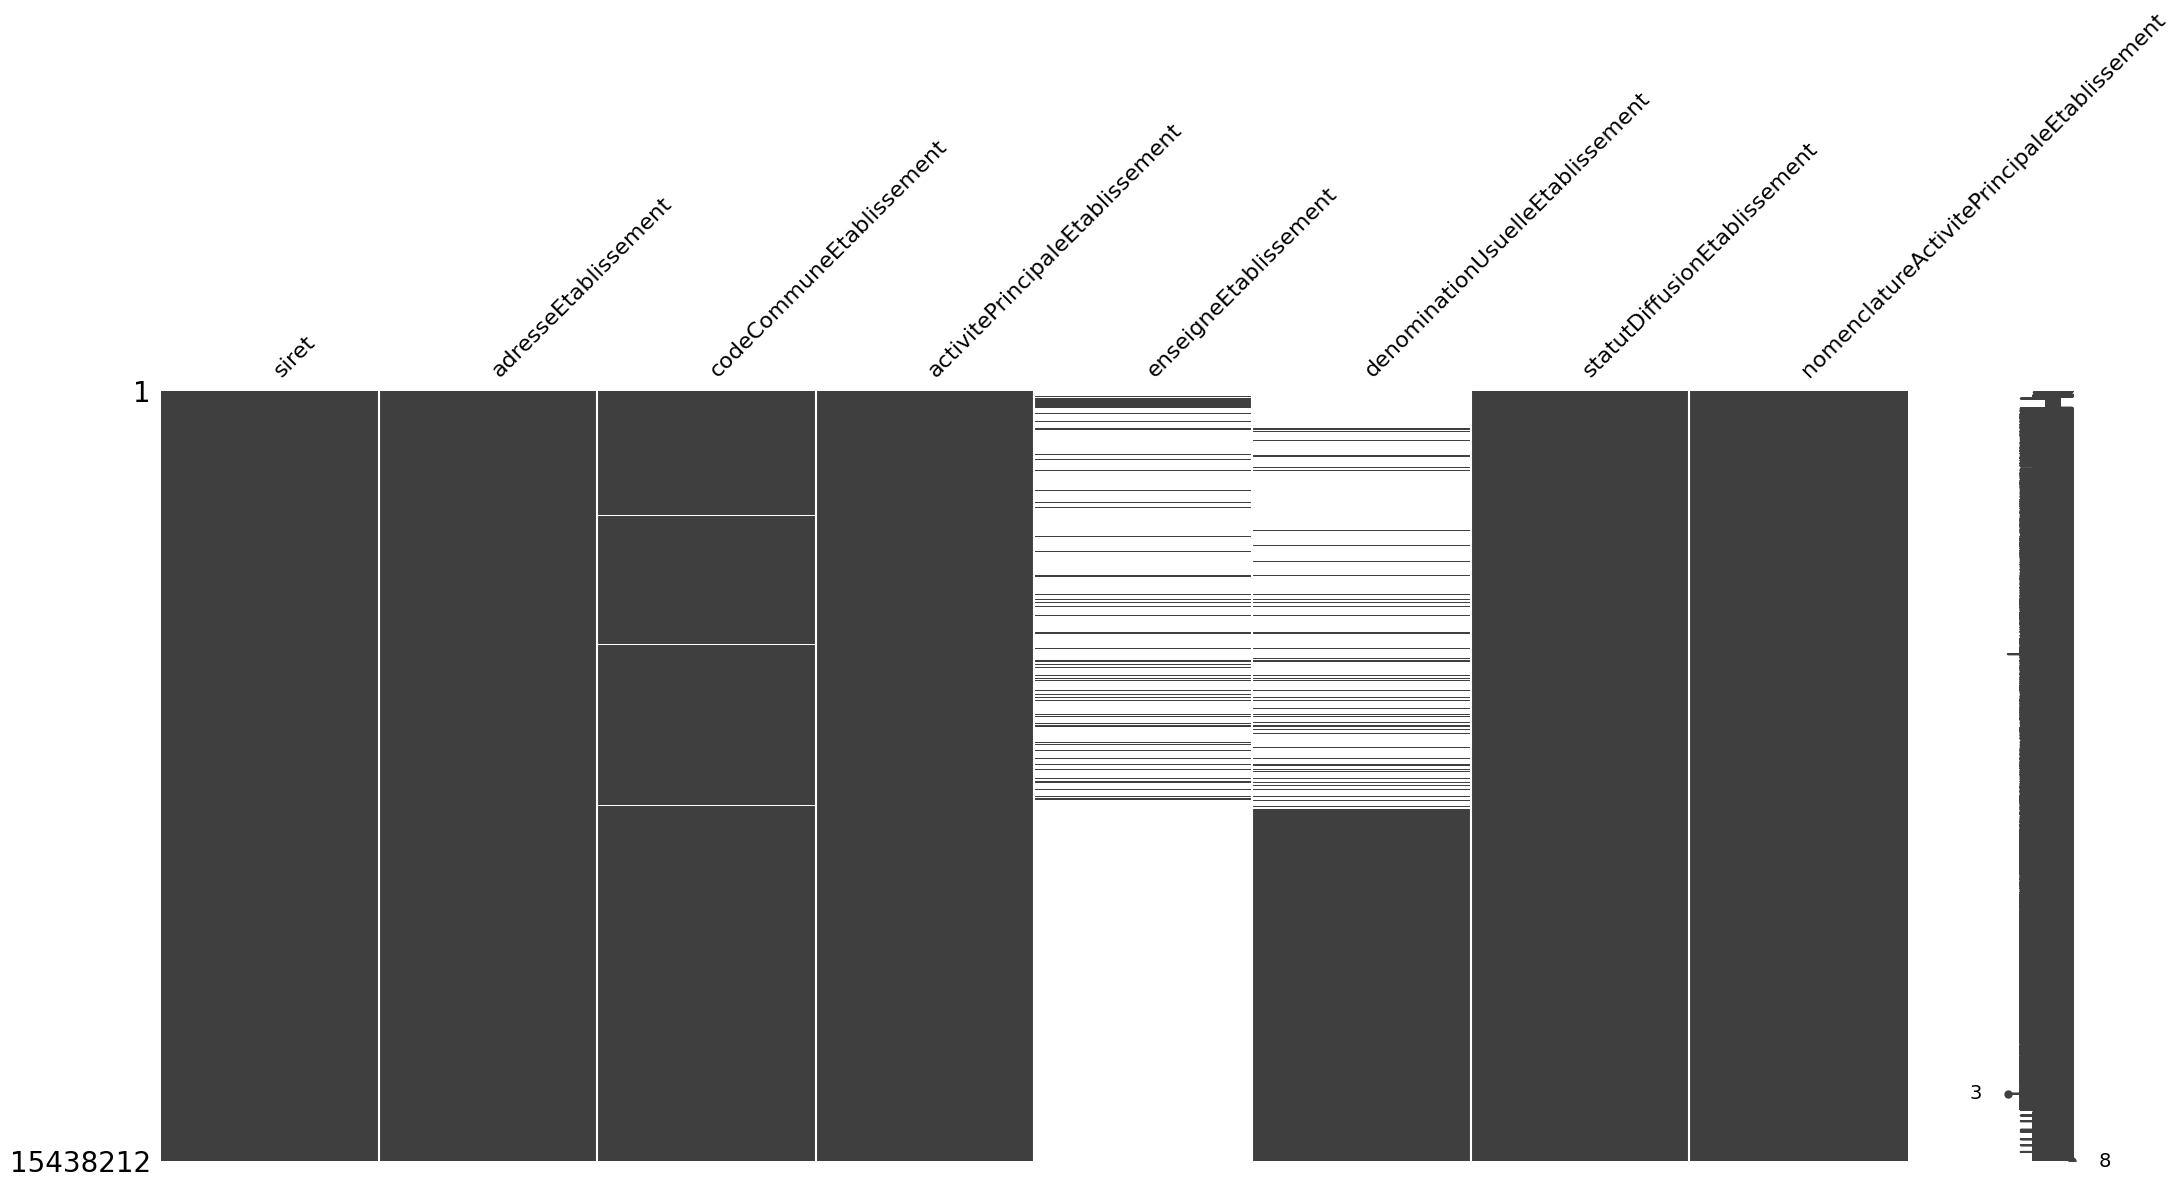

In [26]:
%matplotlib inline

# On regarde la distribution des valeurs manquantes
df_rne.replace("", np.nan, inplace=True)
msno.matrix(df_rne)

# On regarde la distribution des valeurs manquantes
df_sirene.replace("", np.nan, inplace=True)
df_sirene.replace("nan", np.nan, inplace=True)
msno.matrix(df_sirene)

## Enseignements :

- A priori il n'est pas utile de garder enseigneEtablissement pour Sirene : on va le merger avec denomination.
- La moitié des entreprises Sirene n'ont pas de denomination : quelles sont elles ? est il grave de les supprimer ?
- Pour les deux bdd, on peut supprimer celles dont les codecommune sont manquants, elles ne servent à rien.
- Est il pertinent de garder nomenclature pour Sirene ?

### 1. Changer la dénomination de Sirene

<Axes: >

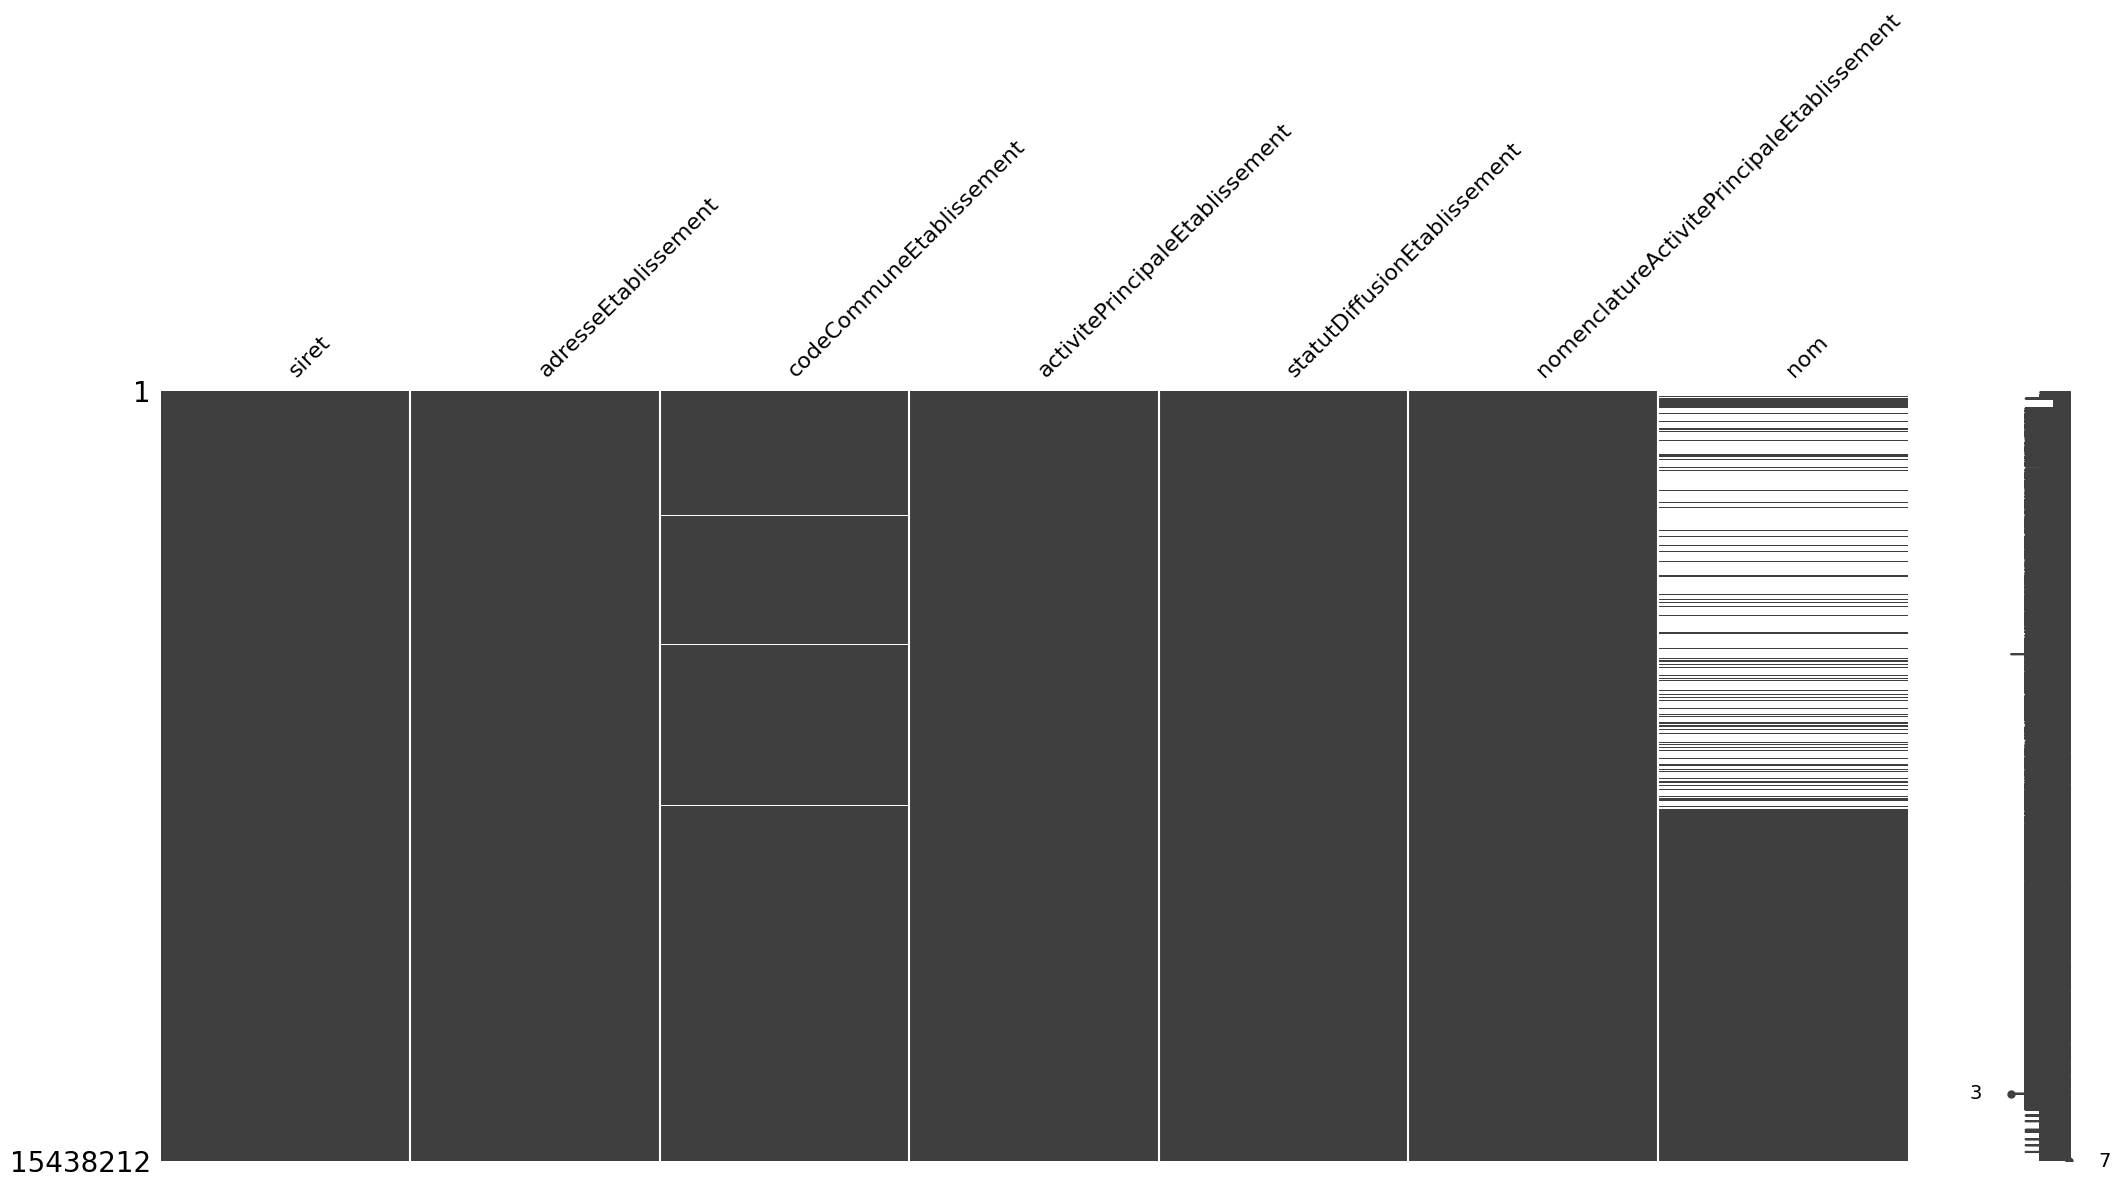

In [29]:
# fonction qui permet de choisir quel nom garder

def new_name(enseigne, denomination):
    
    if pd.isnull(enseigne):
        return denomination
    elif pd.isnull(denomination):
        return enseigne
    elif enseigne == denomination:
        return enseigne
    else:
        # cas où les deux noms sont différents mais non nuls
        # on garde le nom le plus long
        if len(enseigne) > len(denomination):
            return enseigne
        else:
            return denomination
        
# On applique la fonction à la colonne nom
df_sirene["nom"] = df_sirene.apply(lambda x: new_name(x.enseigneEtablissement, x.denominationUsuelleEtablissement), axis=1)

# On supprime les colonnes enseigne et denomination
df_sirene.drop(columns=["enseigneEtablissement", "denominationUsuelleEtablissement"], inplace=True)


# visualisation des valeurs manquantes
msno.matrix(df_sirene)

### 2. Peut on enlever les entreprises dont il manque la dénomination ?

Environ la moitié des entreprises de la base SIRENE sont concernées (ce qui donne a peu près le même nombre de données que RNE soit dit en passant).

Typiquement s'il s'agit d'artisans cela peut valoir le coup de regarder. 

On va s'aider du codeApe pour prendre cette décision.

Celui ci est constitué de la manière suivante [(source)](https://www.ekie.co/fiches-pratiques/code-ape):

<p align="center">
  <img src="../img/codeape.png" alt="imagemanquante" width="30%" />
</p>


On va donc regarder quels secteurs sont les plus touchés par le manque d'information.

<Axes: title={'center': 'Répartition des codes APE des établissements sans nom (effectif > 30000)'}, xlabel='code_branche'>

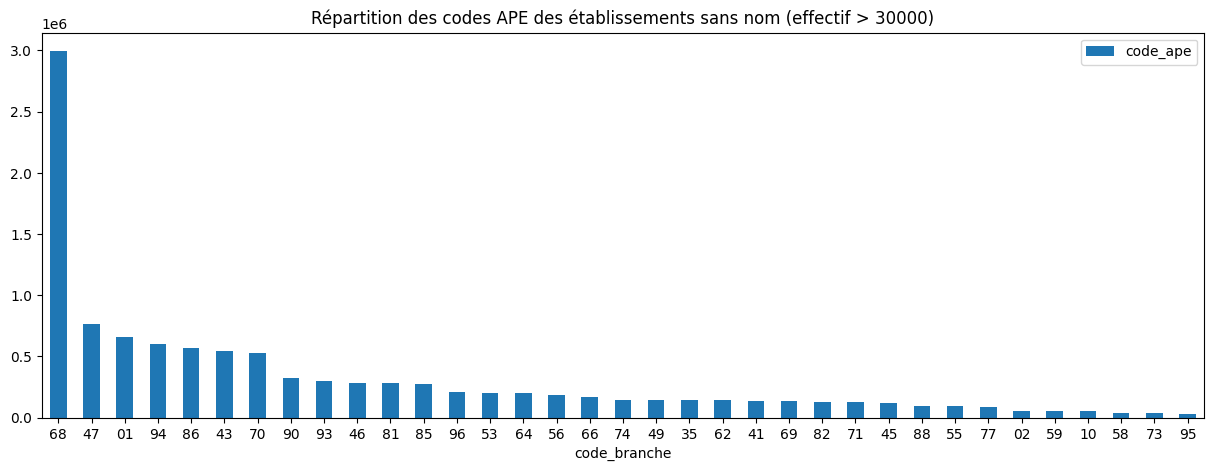

In [48]:


# code ape des établissements sans nom
codes_ape = df_sirene[df_sirene["nom"].isnull()].activitePrincipaleEtablissement.value_counts()

# conversion en dataframe
codes_ape = pd.DataFrame(codes_ape)

# on renomme la colonne
codes_ape.columns = ["code_ape"]

# on ajoute une colonne avec le code de branche d'activité
codes_ape["code_branche"] = codes_ape.index.str[:2]

# on regroupe par code de branche d'activité
codes_ape = codes_ape.groupby("code_branche").sum()

codes_ape.sort_values(by="code_ape", ascending=False, inplace=True)

codes_ape[codes_ape["code_ape"] > 30000].plot.bar(figsize=(15, 5), rot=0, title="Répartition des codes APE des établissements sans nom (effectif > 30000)")

Pour l'instant statuquo sur cette décision : il faudrait creuser (47 correspond au commerce de détail, il peut être intéressant de les garder)

### 3. Suppression des entreprises sans code commune

Pour une app. dont le but est de géolocaliser les entreprises, ça n'a pas grand intérêt de les garder ...

In [51]:
# suppresion des établissements sans code commune
df_rne = df_rne[df_rne["codeInseecommune"].notnull()]
df_sirene = df_sirene[df_sirene["codeCommuneEtablissement"].notnull()]

### 4. Est ce que la colonne Nomenclature est utile ? 

Est ce qu'il y a beaucoup d'autres nomenclatures que Nafrev2 (qui est notre nomenclature de référence).

Si oui : est ce qu'il y a besoin de faire une table de correspondance des différentes nomenclature ?
Si non : peut on la supprimer et supprimer les entreprises correspondantes ?

In [52]:
df_sirene["nomenclatureActivitePrincipaleEtablissement"].value_counts()

nomenclatureActivitePrincipaleEtablissement
NAFRev2    15241019
NAFRev1          20
NAF1993          11
NAP               6
Name: count, dtype: int64

Conclusion : on peut tout supprimer

In [53]:
# suppression des établissments dont la nomenclature n'est pas NAF rév. 2
df_sirene = df_sirene[df_sirene["nomenclatureActivitePrincipaleEtablissement"] == "NAFRev2"]

# suppression de la colonne nomenclatureActivitePrincipaleEtablissement
df_sirene.drop(columns=["nomenclatureActivitePrincipaleEtablissement"], inplace=True)

### Sauvegarde temporaire des dataframes

On pourra au besoin reprendre les données ici

In [30]:
df_sirene.to_parquet("../Données nationales/StockEtablissement_utf8_temp0501.parquet")
df_rne.to_parquet("../Données nationales/RNE_temp0501.parquet")

## Est ce que les deux bases de données sont redondantes ?

I.e. est ce qu'il est utile de garder / merger les deux ?

In [2]:
df_sirene = pd.read_parquet("../Données nationales/StockEtablissement_utf8_temp0501.parquet")
df_rne = pd.read_parquet("../Données nationales/RNE_temp0501.parquet")

In [14]:
# part des siret rne qui sont dans le fichier sirene
nb = len(set(df_rne["siret"].astype(str)).intersection(set(df_sirene["siret"].astype(float).astype(str))))/len(df_rne)
print("Part des siret RNE qui sont dans le fichier SIRENE : {:.2f}%".format(nb*100))

# part des siret sirene qui sont dans le fichier rne
nb = len(set(df_sirene["siret"].astype(float).astype(str)).intersection(set(df_rne["siret"].astype(str))))/len(df_sirene)
print("Part des siret SIRENE qui sont dans le fichier RNE : {:.2f}%".format(nb*100))

Part des siret RNE qui sont dans le fichier SIRENE : 59.66%
Part des siret SIRENE qui sont dans le fichier RNE : 29.88%


## On va créer une base de données qui regroupe les deux sources 

Harmonisation des deux dataframes

In [15]:
# on harmonise les noms des colonnes
df_rne.rename(columns={"adresse": "adresseEtablissement"}, inplace=True)

df_sirene.rename(columns={"codeCommuneEtablissement": "codeInseecommune",
                          "activitePrincipaleEtablissement": "codeApe",
                          "nom": "nomCommercial",
                          "statutDiffusionEtablissement": "diffusionCommerciale"}, inplace=True)

# verif 
print("Les colonnes sont identiques : {}".format(set(df_rne.columns) == set(df_sirene.columns)))

# on harmonise les types des colonnes
df_rne['siret'] = df_rne['siret'].replace("O", "0")
df_rne['siret'] = pd.to_numeric(df_rne['siret'], errors='coerce')
df_sirene.siret = df_sirene.siret.astype('float64')
df_sirene.diffusionCommerciale = df_sirene.diffusionCommerciale.astype(bool)


# test 
print("Les types des colonnes sont identiques : {}".format(set(df_rne.dtypes) == set(df_sirene.dtypes)))


Les colonnes sont identiques : True
Les types des colonnes sont identiques : True


Dans la base SIRENE, les données non diffusées sont notées "[ND]", on va les enlever.

In [16]:
# remplacer toutes les occurences de "[ND]" par "" avec regex
df_sirene.replace(to_replace="\[ND\]", value="", regex=True, inplace=True)



Merge des deux bases

In [26]:
# regroupement des deux bases

df_final = pd.concat([df_rne, df_sirene], ignore_index=True, sort=False)

# on supprime les doublons
df_final.drop_duplicates(subset="siret", inplace=True)

# nouvel index
df_final.reset_index(drop=True, inplace=True)

# infos 
print("Nombre d'établissements dans la base finale : {:,}".format(len(df_final)))

Nombre d'établissements dans la base finale : 18,319,399


# Sauvegarde du fichier final

In [27]:
df_final.to_parquet("../Données nationales/RegistreNationalEtablissementsActifsRneSirene.parquet", index=False)